In [85]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

In [12]:
a = np.random.random((50,2))
a.shape

(50, 2)

In [17]:
np.cov(a.T).shape

(2, 2)

In [9]:
from data.utils import download_data_yf
import importlib
import environment.Market
importlib.reload(environment.Market)
from environment.Market import Market
import environment.Market
importlib.reload(environment.Market)
from environment.Market import Market
tickers = ["AAPL", "MSFT"]
start_date = "2020-01-01"
end_date = "2024-01-01"



data = download_data_yf(tickers=tickers, start_date=start_date, end_date=end_date)
data


[*********************100%***********************]  2 of 2 completed
c:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\beta\data\utils.py:21: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=0).reset_index()


Price,Date,Ticker,Open,High,Low,Close,Volume
0,2020-01-02,AAPL,71.799881,72.856621,71.545395,72.796028,135480400
1,2020-01-02,MSFT,151.870732,153.735875,151.440316,153.630661,22622100
2,2020-01-03,AAPL,72.020432,72.851761,71.862892,72.088295,146322800
3,2020-01-03,MSFT,151.430809,152.989871,151.182113,151.717743,21116200
4,2020-01-06,AAPL,71.206070,72.701492,70.954002,72.662712,118387200
...,...,...,...,...,...,...,...
2007,2023-12-27,MSFT,370.916334,372.276160,370.042861,371.293518,14905400
2008,2023-12-28,AAPL,193.193559,193.711028,192.228287,192.636292,34049900
2009,2023-12-28,MSFT,372.583835,373.665741,371.382825,372.494507,14327000
2010,2023-12-29,AAPL,192.954701,193.452263,190.795282,191.591385,42628800


In [20]:
mkt = Market(data, len(tickers), dt.datetime(2022,1,1))
mkt.get_n_past_returns(4).drop('Date', axis=1)

The current day must be in the data, looking for the closest day
Current day set to 2021-12-31 00:00:00


,AAPL,MSFT
1,-0.005767,-0.003504
2,0.000502,0.002051
3,-0.006578,-0.007691
4,-0.003535,-0.008841


In [35]:
import beta.agents.simple_agents as simple_agents 
importlib.reload(simple_agents)
from beta.agents.simple_agents import static_agent_simulation
mets = static_agent_simulation("C:/Users/m.narese/Desktop/THESIS/REPO/portfolio_optimization/beta/runs_data/dynamic_optimization/static_base.yaml")

[*********************100%***********************]  8 of 8 completed
c:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\beta\data\utils.py:21: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=0).reset_index()


The current day must be in the data, looking for the closest day
Current day set to 2020-01-02 00:00:00


In [36]:
from beta.optimization.simulation.standard_MC import PortfolioOptimizer
optimizer = PortfolioOptimizer(mkt.get_n_past_returns(4).drop('Date', axis=1))
optimizer.num_assets

2

In [ ]:
yf.download("AAPL")

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
1980-12-12,0.098834,0.099264,0.098834,0.098834,469033600
1980-12-15,0.093678,0.094108,0.093678,0.094108,175884800
1980-12-16,0.086802,0.087232,0.086802,0.087232,105728000
1980-12-17,0.088951,0.089381,0.088951,0.088951,86441600
1980-12-18,0.091530,0.091959,0.091530,0.091530,73449600
...,...,...,...,...,...
2025-01-15,237.869995,238.960007,234.429993,234.639999,39832000
2025-01-16,228.259995,238.009995,228.029999,237.350006,71759100


In [83]:
weights = np.ones(3)/3
from beta.forecaster.models.estimators import sample_covariance, sample_mean

(np.dot(sample_mean(mkt.get_n_past_returns(4).drop('Date', axis=1)-1),weights[1:])*255 + weights[0]*0.03 - 0.03)/((1-weights[0])*np.sqrt(np.dot(np.dot(weights[1:], sample_covariance(mkt.get_n_past_returns(4).drop('Date', axis=1)-1)), weights[1:])))


np.float64(-1624889.6559324008)

In [81]:
(np.dot(sample_mean(mkt.get_n_past_returns(4).drop('Date', axis=1))-1,weights[1:])*255 + weights[0]*0.03 - 0.03)

np.float64(-350.8110019049206)

In [66]:
import beta.agents.MC_simulation_agent as MC_simulation_agent 
importlib.reload(MC_simulation_agent)
from beta.agents.MC_simulation_agent import MC_simulated_optimization
mets = MC_simulated_optimization("C:/Users/m.narese/Desktop/THESIS/REPO/portfolio_optimization/beta/runs_data/dynamic_optimization/MC_base.yaml")

[*********************100%***********************]  8 of 8 completed
c:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\beta\data\utils.py:21: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=0).reset_index()


The current day must be in the data, looking for the closest day
Current day set to 2021-12-31 00:00:00


AssertionError: Criterion function must return a scalar (8,)

In [48]:
import beta.agents.simple_agents as simple_agents 
importlib.reload(simple_agents)
from beta.agents.simple_agents import periodic_review_simulation
mets_per = periodic_review_simulation("C:/Users/m.narese/Desktop/THESIS/REPO/portfolio_optimization/beta/runs_data/dynamic_optimization/periodic_base.yaml")

[*********************100%***********************]  8 of 8 completed
c:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\beta\data\utils.py:21: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=0).reset_index()


The current day must be in the data, looking for the closest day
Current day set to 2020-01-02 00:00:00


c:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\beta\environment\Portfolio.py:49: RuntimeWarning: overflow encountered in scalar multiply
  self.current_value = np.sum(self.weights)*self.current_value


In [344]:
import data.utils
importlib.reload(data.utils)
from data.utils import download_data_yf
with open("C:/Users/m.narese/Desktop/THESIS/REPO/portfolio_optimization/beta/runs_data/dynamic_optimization/static_base.yaml", "r") as f:
          yaml_data = f.read()
configs = OmegaConf.create(yaml_data)

if configs.data.yahoo_finance:
    tickers = list(configs.data.tickers)
    data = download_data_yf(tickers, configs.data.start_date, configs.data.end_date)

[*********************100%***********************]  8 of 8 completed
c:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\beta\data\utils.py:21: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=0).reset_index(future_stack=True)


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-03   2020-01-03
End Period                 2023-12-29   2023-12-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          55.81%       150.81%
CAGR﹪                     7.98%        17.25%

Sharpe                     0.61         0.86
Prob. Sharpe Ratio         88.38%       95.51%
Smart Sharpe               0.55         0.78
Sortino                    0.84         1.22
Smart Sortino              0.77         1.11
Sortino/√2                 0.6          0.86
Smart Sortino/√2           0.54         0.79
Omega                      1.16         1.16

Max Drawdown               -33.72%      -48.92%
Longest DD Days            708          726
Volatility (ann.)          22.63%       33.52%
R^2                        0.01         0.01
Information Ratio          0.02         0.02
Calmar            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-03,2023-01-04,2023-12-29,726,-48.919399,-47.069354
2,2020-02-19,2020-03-20,2020-06-08,111,-30.266218,-29.173469
3,2021-01-26,2021-03-05,2021-08-26,213,-19.238533,-16.109555
4,2020-08-31,2020-09-04,2020-11-20,82,-16.520828,-15.095542
5,2021-11-04,2021-12-17,2021-12-30,57,-14.386900,-12.557444


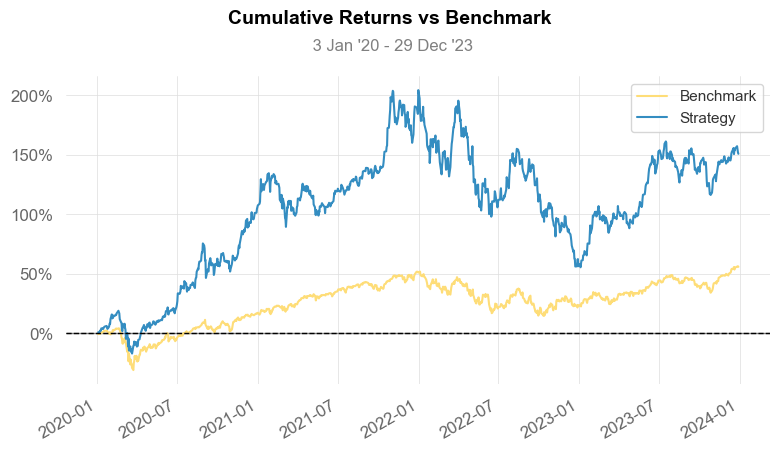

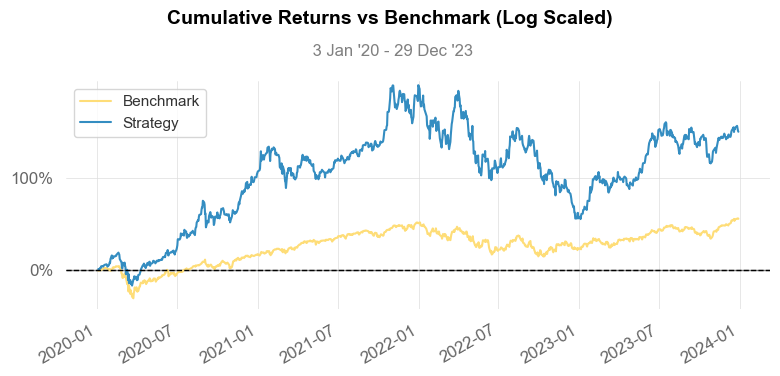

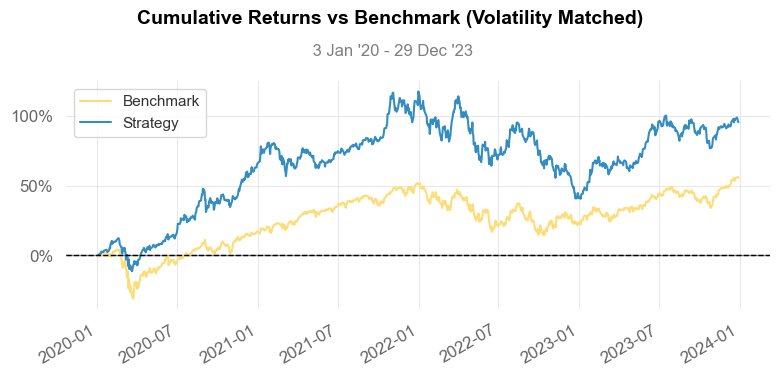

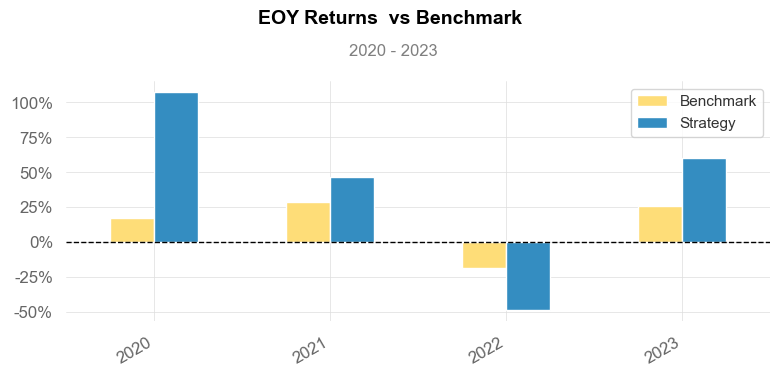

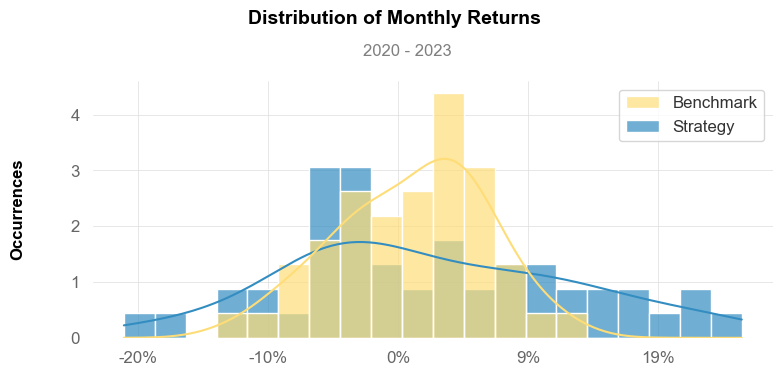

C:\Users\m.narese\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\quantstats\_plotting\core.py:294: FutureWarning: Passing additional kwargs to DatetimeIndexResampler.sum has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  returns = returns.last() if compound is True else returns.sum(axis=0)


UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [387]:
import quantstats as qs
days = [str(mets["days"][i]) for i in range(len(mets["days"]))]
porst = pd.DataFrame({"Date":days, "Return": [mets["portfolio_returns"][i]-1 for i in range(len(mets["portfolio_returns"]))]})
porst["Date"] = pd.to_datetime(porst["Date"])

# Set Date as the index and pass only the 'Return' column
porst.set_index("Date", inplace=True)

# Ensure the 'Return' column is a pd.Series
returns_series = porst["Return"]

days = [str(mets_per["days"][i]) for i in range(len(mets_per["days"]))]
porst2 = pd.DataFrame({"Date":days, "Return": [mets_per["portfolio_returns"][i]-1 for i in range(len(mets_per["portfolio_returns"]))]})
porst2["Date"] = pd.to_datetime(porst2["Date"])

# Set Date as the index and pass only the 'Return' column
porst2.set_index("Date", inplace=True)

# Ensure the 'Return' column is a pd.Series
returns_series_per = porst2["Return"]

# Call qs.reports.plots on the returns Series
qs.reports.full(returns_series, benchmark="SPY")


In [276]:
start_prices = data[data["Date"] == dt.datetime(2021, 5, 5)][["Close", "Ticker", "Date"]]
start_prices = start_prices.pivot(index='Date', columns='Ticker', values='Close')

# Optional: Rename columns to include "_pct_change" for clarity
start_prices.columns = [f"{ticker}" for ticker in start_prices.columns]

# Reset the index if needed
start_prices.reset_index(inplace=True)

end_prices = data[data["Date"] == pd.to_datetime(mkt.today())][["Close", "Ticker", "Date"]]

end_prices = end_prices.pivot(index='Date', columns='Ticker', values='Close')

# Optional: Rename columns to include "_pct_change" for clarity
end_prices.columns = [f"{ticker}" for ticker in end_prices.columns]

# Reset the index if needed
end_prices.reset_index(inplace=True)
a = pd.concat([start_prices, end_prices], axis=0)
a =a.drop(columns="Date").pct_change().dropna()


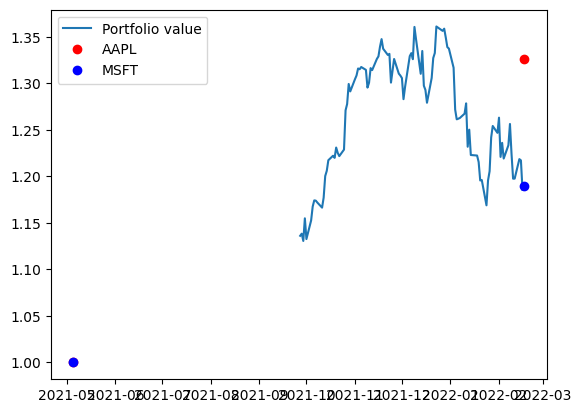

In [278]:
plt.plot(day, evolution, label = "Portfolio value")
plt.plot([dt.datetime(2021, 5, 5), mkt.today()], [1, a["AAPL"].values[0] + 1], 'ro', label = "AAPL")
plt.plot([dt.datetime(2021, 5, 5), mkt.today()], [1, a["MSFT"].values[0] + 1], 'bo', label = "MSFT")
plt.legend()
plt.show()

In [3]:


data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by=['Ticker', 'Date'])

# Group by Ticker and calculate percentage change
data['Pct_Change'] = data.groupby('Ticker')['Close'].pct_change()

# Pivot the DataFrame to get tickers as columns
pivoted_data = data.pivot(index='Date', columns='Ticker', values='Pct_Change')

# Optional: Rename columns to include "_pct_change" for clarity
pivoted_data.columns = [f"{ticker}_pct_change" for ticker in pivoted_data.columns]

# Reset the index if needed
pivoted_data.reset_index(inplace=True)

print(pivoted_data)

          Date  AAPL_pct_change  MSFT_pct_change
0   2010-01-04              NaN              NaN
1   2010-01-05         0.001729         0.000323
2   2010-01-06        -0.015906        -0.006137
3   2010-01-07        -0.001849        -0.010399
4   2010-01-08         0.006648         0.006897
..         ...              ...              ...
499 2011-12-23         0.011993         0.008524
500 2011-12-27         0.007934         0.000384
501 2011-12-28        -0.009569        -0.008448
502 2011-12-29         0.006159         0.007746
503 2011-12-30        -0.000296        -0.002306

[504 rows x 3 columns]


In [4]:
data[1:3]

Price,Date,Ticker,Open,High,Low,Close,Volume,Pct_Change
2,2010-01-05,AAPL,6.465187,6.495012,6.424515,6.458559,601904800,0.001729
4,2010-01-06,AAPL,6.458559,6.484167,6.349199,6.355827,552160000,-0.015906


In [5]:
wf = 30
x_train = []
y_train = []
for company in data["Ticker"].unique():
    data_company = data[data["Ticker"] == company]
    for i in range(wf, len(data_company)):
        x_train.append(data_company[i-wf:i][["Open", "High", "Low", "Close", "Volume"]])
        y_train.append(data_company[i:i+1]["Close"])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 5))


In [6]:
x_train.shape, y_train.shape

((948, 30, 5), (948, 1))

In [ ]:

def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 5)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model